# Weight tracking, analysis and forecast

## Setup

In [1]:
import numpy as np
import datetime
from datetime import date
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import os
import sys
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
print(f'Python = {sys.version}')
print(f'Numpy = {np.__version__}')
print(f'Tensorflow = {tf.__version__}')

Python = 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Numpy = 1.20.3
Tensorflow = 2.5.0


In [3]:
import weightlib as wl

# Data Extraction

Les "données brutes" sont récupérées de deux fichiers :

=> file "data_BEN.zip" contains the file "weight.csv" with all daily measurements of total mass, fat mass.

=> file "Suivi_Poids.csv" has manually-entered daily numbers for total mass and fat mass, plus nutrition data (lipid, carbs, proteines), and calories data (ingested, spent with cardio, spent with strength training)

In [4]:
ROOT = os.getcwd() + '/'
print(f'current working directory is {ROOT}')
print(f'contains :')
print(f'{os.listdir(ROOT)}')

current working directory is c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/
contains :
['.git', '.ipynb_checkpoints', 'data_BEN.zip', 'desktop.ini', 'figure.jpg', 'Glycogene_metabolisme_effort.pdf', 'model.png', 'pat.txt', 'polar-user-data-export.zip', 'README.md', 'Suivi_Poids.csv', 'test_methodes.xlsx', 'tmp', 'weight.ipynb', 'weightlib.py', 'weight_arima.ipynb', 'weight_rapport.ipynb', 'weight_recherche.ipynb', '__pycache__']


In [5]:
ds = wl.GetData(ROOT + 'data_BEN.zip', ROOT + 'Suivi_Poids.csv')

In [6]:
ds.extract()

Extraction fichier Zip Healthmate dans c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/tmp...
... Done


In [7]:
raw_df = ds.get_dataframe()

raw_df.set_index('date', inplace=True)

In [8]:
raw_df

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,duree_exercice
date,,,,,,,,,,
2020-09-01,101.250000,33.020000,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,28.0
2020-09-02,101.150000,31.945000,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,41.0
2020-09-03,101.200000,30.930000,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,40.0
2020-09-04,100.800000,29.460000,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,43.0
2020-09-05,100.600000,31.450000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,47.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-28,68.208333,8.505833,2112.0,188.0,67.0,184.0,466.0,0.0,466.0,85.0
2021-12-29,68.968182,8.809091,2111.0,172.0,78.0,183.0,651.0,0.0,651.0,81.0
2021-12-30,68.512500,8.412500,1846.0,174.0,62.0,150.0,0.0,0.0,0.0,0.0


### Dataframe with 'engineered' features

In [9]:
df = raw_df

In [10]:
BMR_to_RMR_multiplier = 1.10  # arbitrary coefficient to go from Base Metabolism Rate to Rest Metabolism Rate

In [11]:
# calcule colonnes masse sèche, body fat % age, base metabolism, rest metabolism

df.insert( loc=list(df.columns).index('masse_grasse')+1,
          column = 'masse_seche',
          value = df['masse_totale'] - df['masse_grasse']
)

df.insert( loc=list(df.columns).index('masse_seche')+1,
          column = 'body_fat_percentage',
          value = df['masse_grasse'] / df['masse_totale']
)

df.insert( loc=list(df.columns).index('body_fat_percentage')+1,
          column = 'base_metabolism_rate',
          value = df['masse_seche'].apply(wl.kma)  # on utilise Katch Mac Ardle pour métabolisme de base : 370 + 21.6 * masse_seche
)

df.insert( loc=list(df.columns).index('base_metabolism_rate')+1,
          column = 'rest_metabolism_rate',
          value = df['base_metabolism_rate'] * BMR_to_RMR_multiplier
)


### Travail sur les calories d'exercice :
- prise en compte des variations de VO² max
- passage des calories brutes aux calories nettes

In [12]:
df.insert( loc = list(df.columns).index('calories_strength')+1,
          column = 'VO2_max',
          value = 0.0
          )

### Prise en compte du changement de VO² max !
- 27/3/2021, 4/5/2021 : VO² max = 39 ml/kg/min => TRES BAS !! ON PRENDRA V² max = 55.0 au 1er MARS 2021
- 29,30,31/12/2021 : VO² max = 64,67,67 ml/kg/min

Hypothèses de calcul : 
- constant à 55 ml/kg/min jusqu'au 1/3/2021
- constant à 67 ml/kg/min depuis le 29/12/2021
- linéaire entre les deux dates
- les calories d'exercice sont recalculées suivant : Male: ((-95.7735 + (0.634 x HR) + (0.404 x VO2max) + (0.394 x W) + (0.271 x A))/4.184) x 60 x T
- soit : new_cals = old_cals x VO²_new / VO²_old
- 
- (ref = http://www.shapesense.com/fitness-exercise/calculators/heart-rate-based-calorie-burn-calculator.shtml)

In [13]:
start_date = datetime.date(2021,3,1)
start_VO2 = 55.0  # GROSSE HYPOTHESE : VO² max = 55 ml/kg/min au 1er mars 2021...

end_date = datetime.date(2021,12,29)
end_VO2 = 66.0

In [14]:
df.loc[df.index <= start_date, 'VO2_max'] = start_VO2
df.loc[df.index >= end_date, 'VO2_max'] = end_VO2

dates = [ start_date + datetime.timedelta(i) for i in range(0, end_date.toordinal() - start_date.toordinal())]

pente = (end_VO2 - start_VO2) / (end_date.toordinal() - start_date.toordinal())

for d in dates:
    df.loc[d, 'VO2_max'] = start_VO2 + pente * (d.toordinal() - start_date.toordinal())

### Maintenant, on recalcule les calories d'exercice antérieurement au 29/12, en prenant en compte les valeurs calculées de VO² max, 

Puis calculer les valeurs nettes (hors RMR) après avoir importé les durées d'exercice

In [15]:
raw = [ 'calories_exercice',
       'calories_cardio',
       'calories_strength'
       ]

revised = ['calories_exercice_net',
       'calories_cardio_net',
       'calories_strength_net'
       ]

for r1, r2 in zip(raw, revised):
       delta_net_cals = df[[r1,'rest_metabolism_rate', 'duree_exercice']].apply( lambda x : (x[r1] > 0.0) * x['duree_exercice'] / 60 * x['rest_metabolism_rate'] / 24 , axis=1 )
       df.loc[ df.index < end_date, r2 ] = df[[r1,'VO2_max']].apply( lambda x : x[r1] * x['VO2_max'] / start_VO2, axis=1 )
       df.loc[ df.index >= end_date, r2] = df.loc[ df.index >= end_date, r1 ]
       df[r2] = df[r2] - delta_net_cals

In [16]:
df.insert( loc=list(df.columns).index('calories_strength_net')+1,
          column = 'calories_deficit',
          value = df['calories_in'] - df['rest_metabolism_rate'] - df['calories_exercice_net']
)

In [17]:
df

,masse_totale,masse_grasse,masse_seche,body_fat_percentage,base_metabolism_rate,rest_metabolism_rate,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,VO2_max,duree_exercice,calories_exercice_net,calories_cardio_net,calories_strength_net,calories_deficit
date,,,,,,,,,,,,,,,,,,,
2020-09-01,101.250000,33.020000,68.230000,0.326123,1843.768000,2028.14480,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,55.000000,28.0,241.563851,241.563851,0.000000,-254.708651
2020-09-02,101.150000,31.945000,69.205000,0.315818,1864.828000,2051.31080,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,55.000000,41.0,360.594623,360.594623,0.000000,-469.905423
2020-09-03,101.200000,30.930000,70.270000,0.305632,1887.832000,2076.61520,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,55.000000,40.0,345.316244,345.316244,0.000000,-483.931444
2020-09-04,100.800000,29.460000,71.340000,0.292262,1910.944000,2102.03840,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,55.000000,43.0,376.230798,376.230798,0.000000,-627.269198
2020-09-05,100.600000,31.450000,69.150000,0.312624,1863.640000,2050.00400,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,55.000000,47.0,496.090147,496.090147,0.000000,-772.094147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,68.208333,8.505833,59.702500,0.124704,1659.574000,1825.53140,2112.0,188.0,67.0,184.0,466.0,0.0,466.0,65.963696,85.0,451.135347,0.000000,451.135347,-164.666747
2021-12-29,68.968182,8.809091,60.159091,0.127727,1669.436364,1836.38000,2111.0,172.0,78.0,183.0,651.0,0.0,651.0,66.000000,81.0,547.703625,0.000000,547.703625,-273.083625
2021-12-30,68.512500,8.412500,60.100000,0.122788,1668.160000,1834.97600,1846.0,174.0,62.0,150.0,0.0,0.0,0.0,66.000000,0.0,0.000000,0.000000,0.000000,11.024000


### Quelques graphes

# Depuis le début

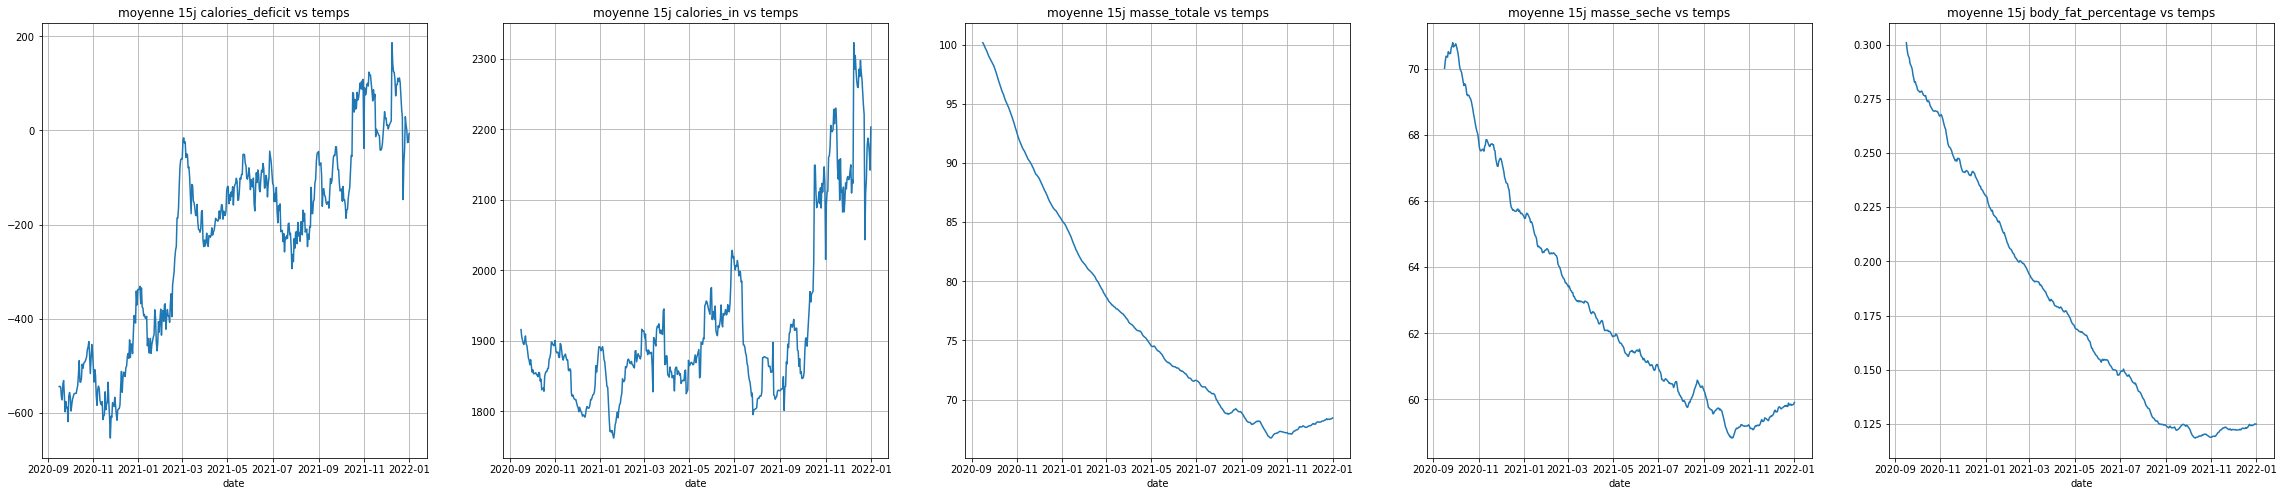

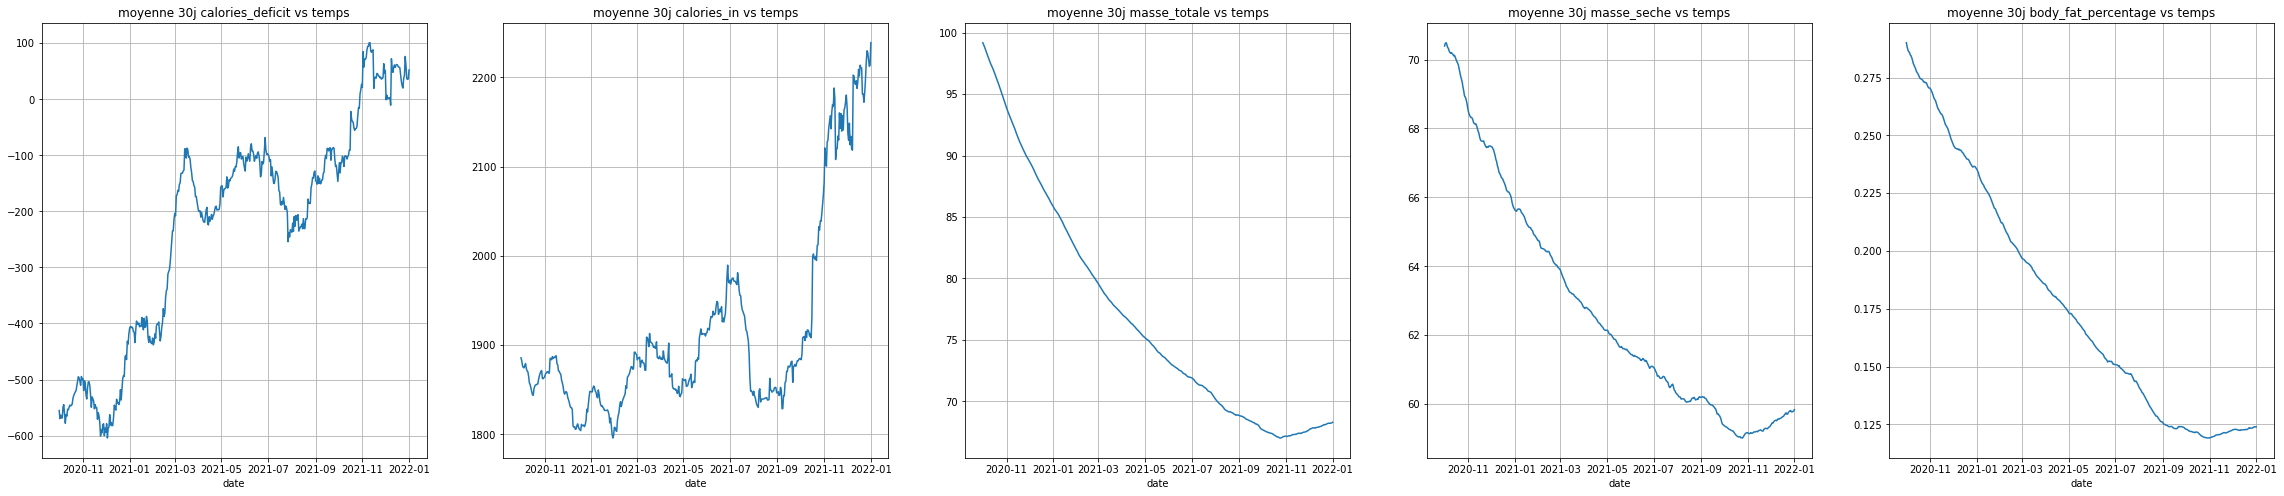

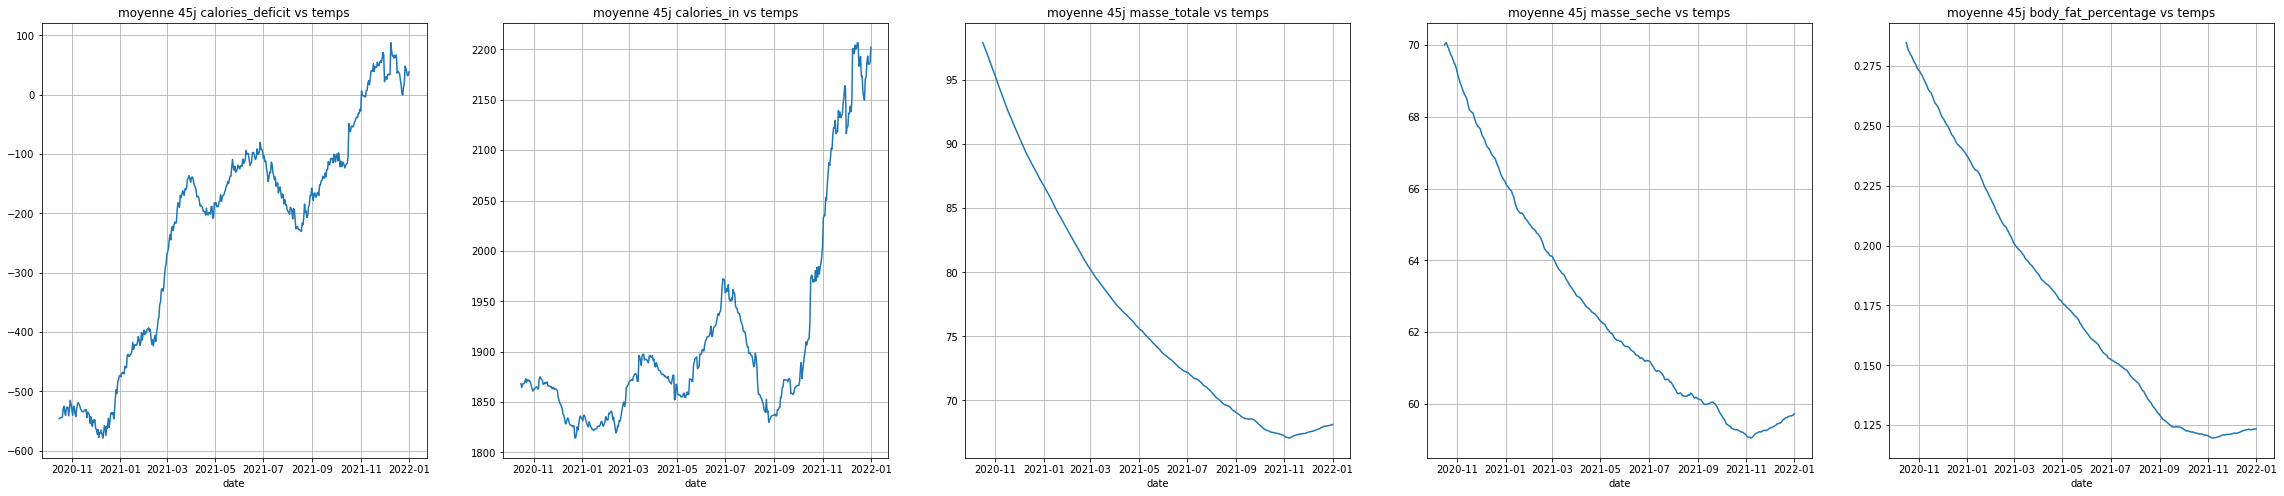

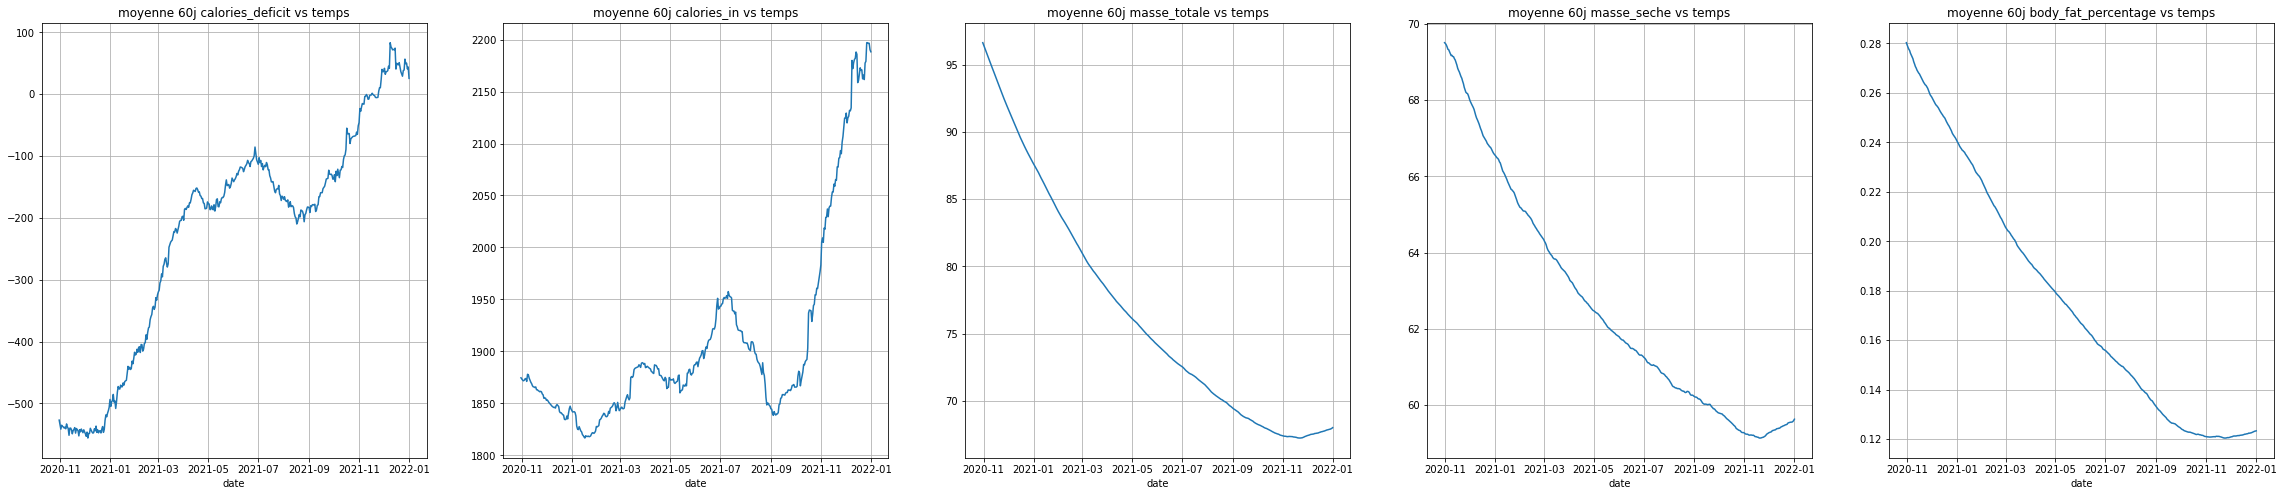

In [18]:
window_list = [15,30,45, 60]

for w in window_list:
    wl.plot_moyennes(df, list_of_moyennes=['calories_deficit', 'calories_in', 'masse_totale', 'masse_seche', 'body_fat_percentage'], window=w)

# Depuis les 90 derniers jours

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


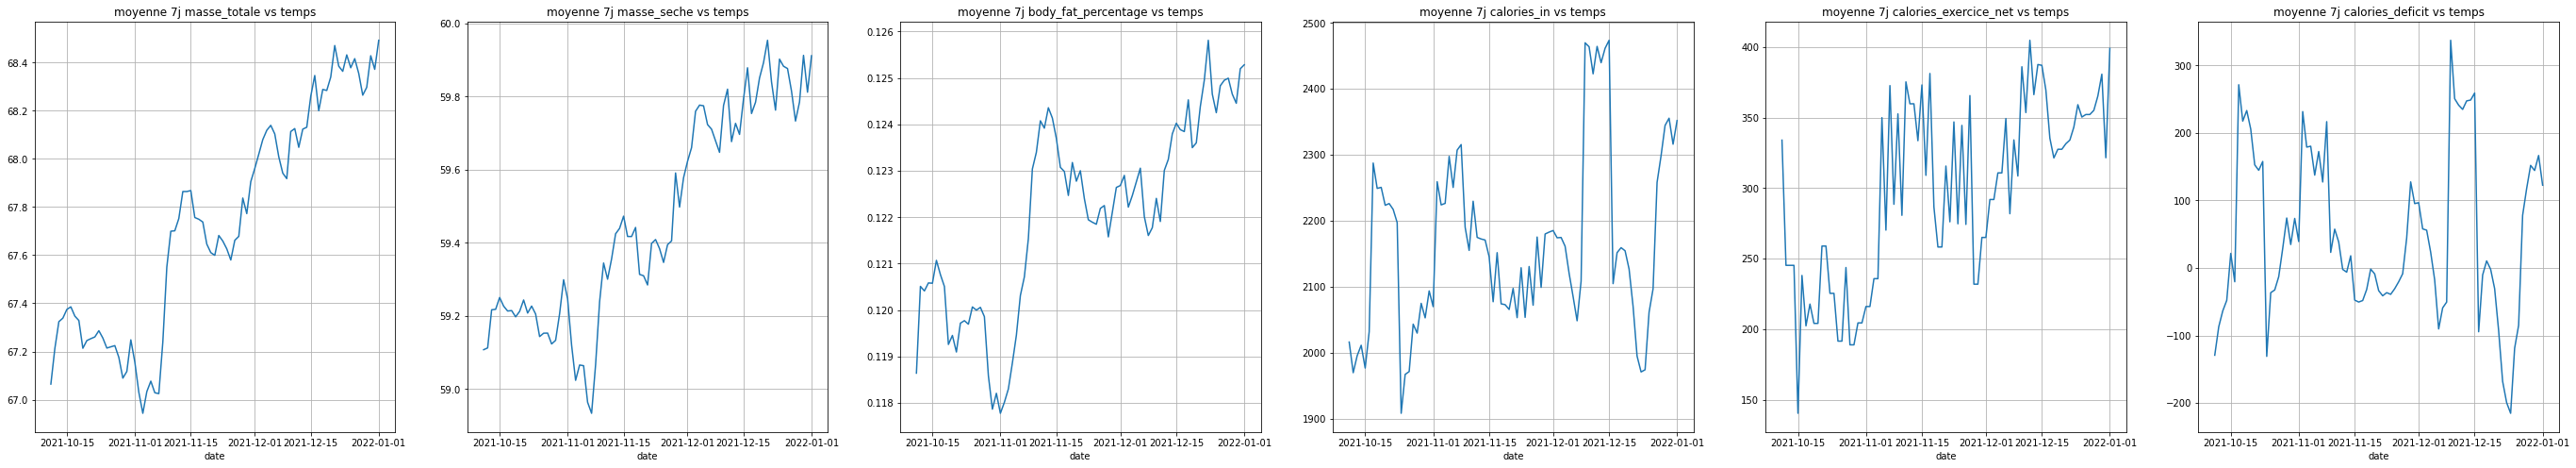

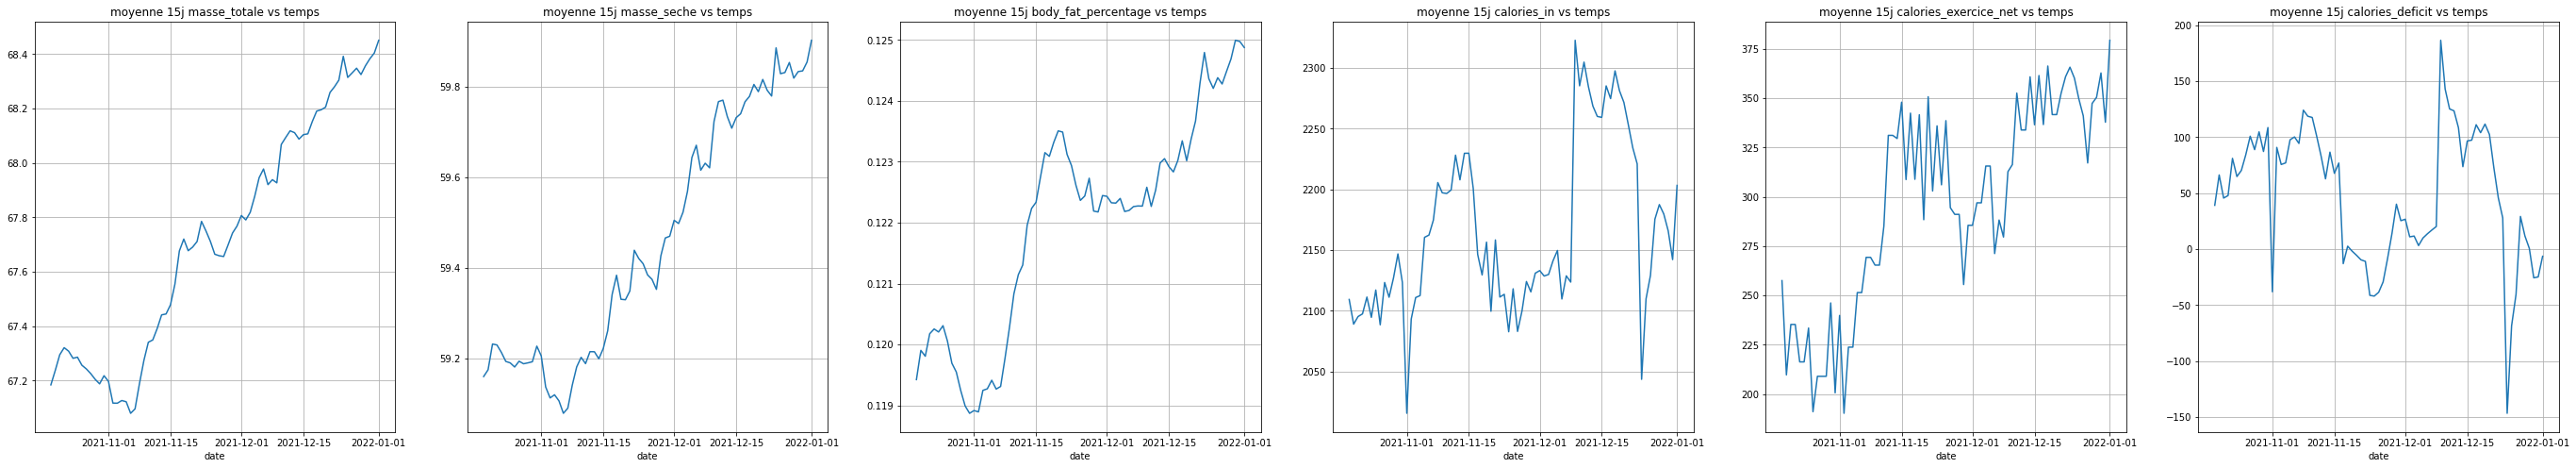

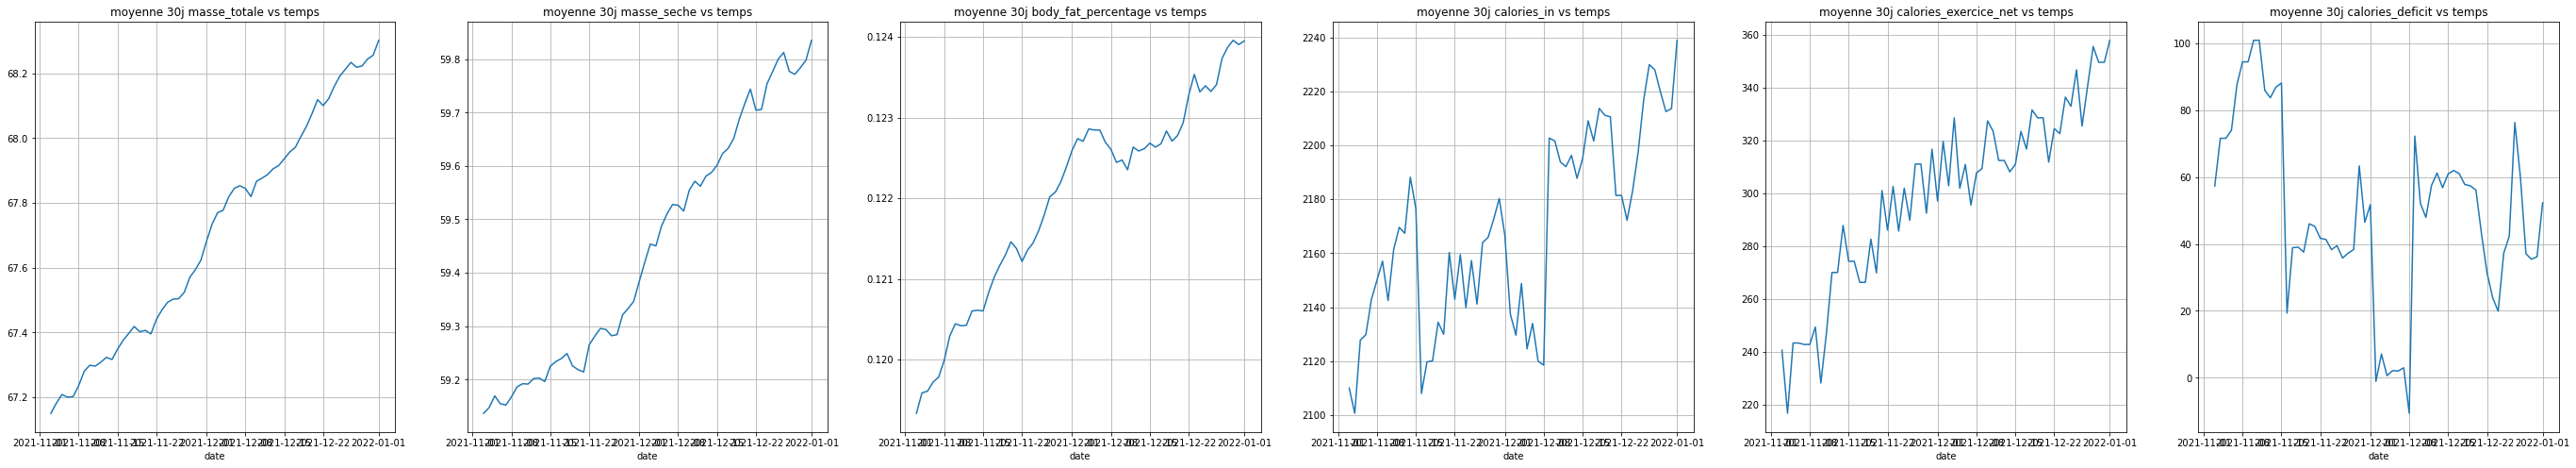

In [19]:
over_last_days = 90

start_date = datetime.date.today() - datetime.timedelta(days = over_last_days)
index_to_drop = [df.index < start_date]

df_last = df.drop(index = df.index[index_to_drop])

window_list = [7,15,30]

for w in window_list:
    wl.plot_moyennes(df=df_last, list_of_moyennes=['masse_totale', 'masse_seche', 'body_fat_percentage', 'calories_in', 'calories_exercice_net', 'calories_deficit'], window=w)

# On distingue deux périodes :
- une période de "sèche" jusqu'à fin septembre 2021 environ
- une période de "bulk" plus ou moins clean (?) à partir d'octobre 2021

In [20]:
cut_off = datetime.date(2021,10,1)

df_seche = df[df.index < cut_off]

df_bulk = df[df.index >= cut_off]


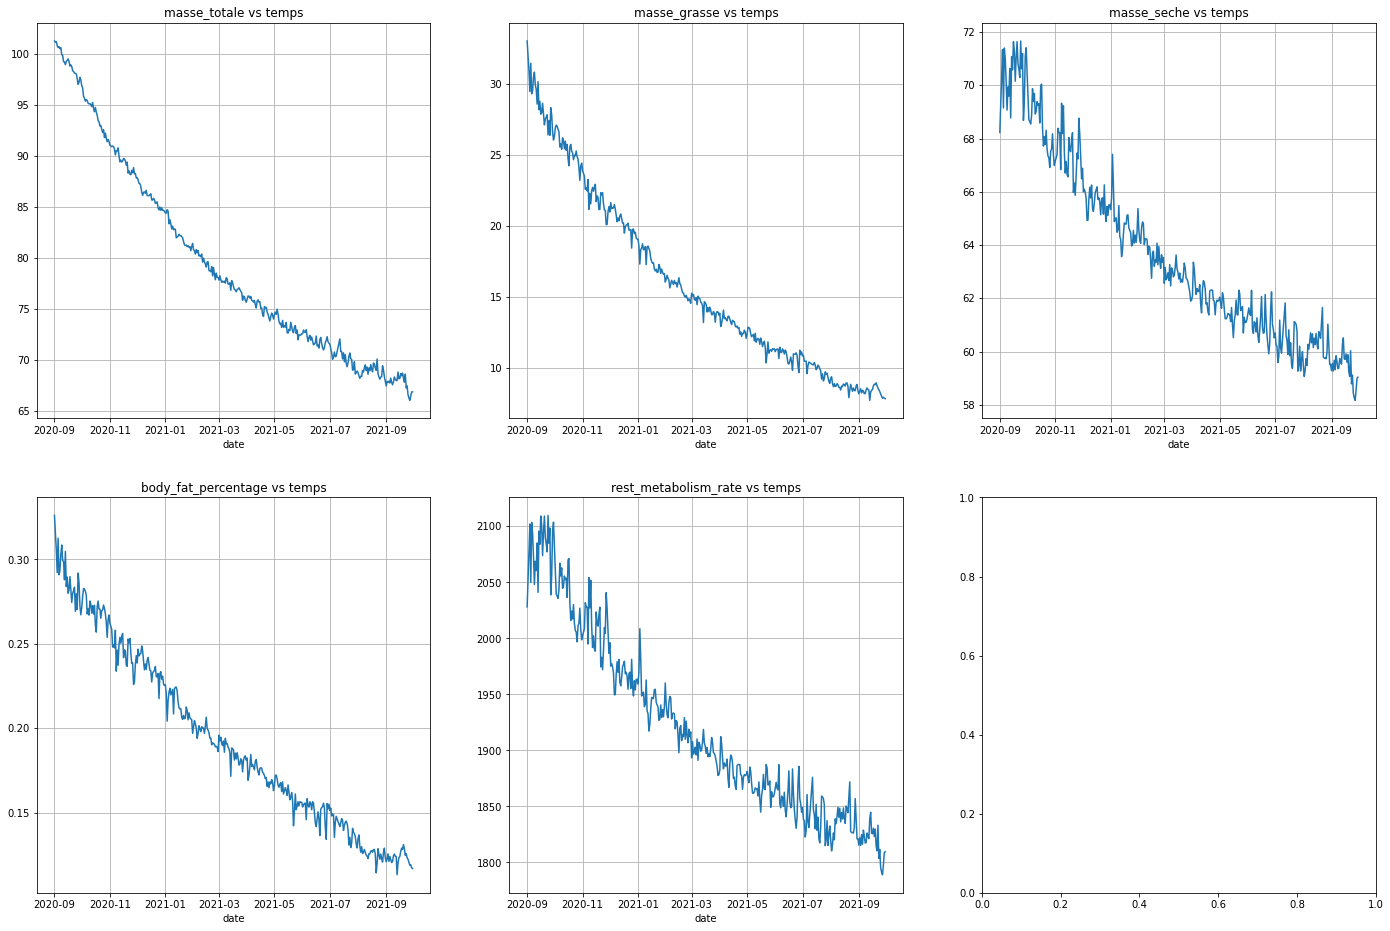

In [21]:
wl.plot_columns(df=df_seche,
                columns_list=['masse_totale', 'masse_grasse', 'masse_seche', 'body_fat_percentage', 'rest_metabolism_rate']
)

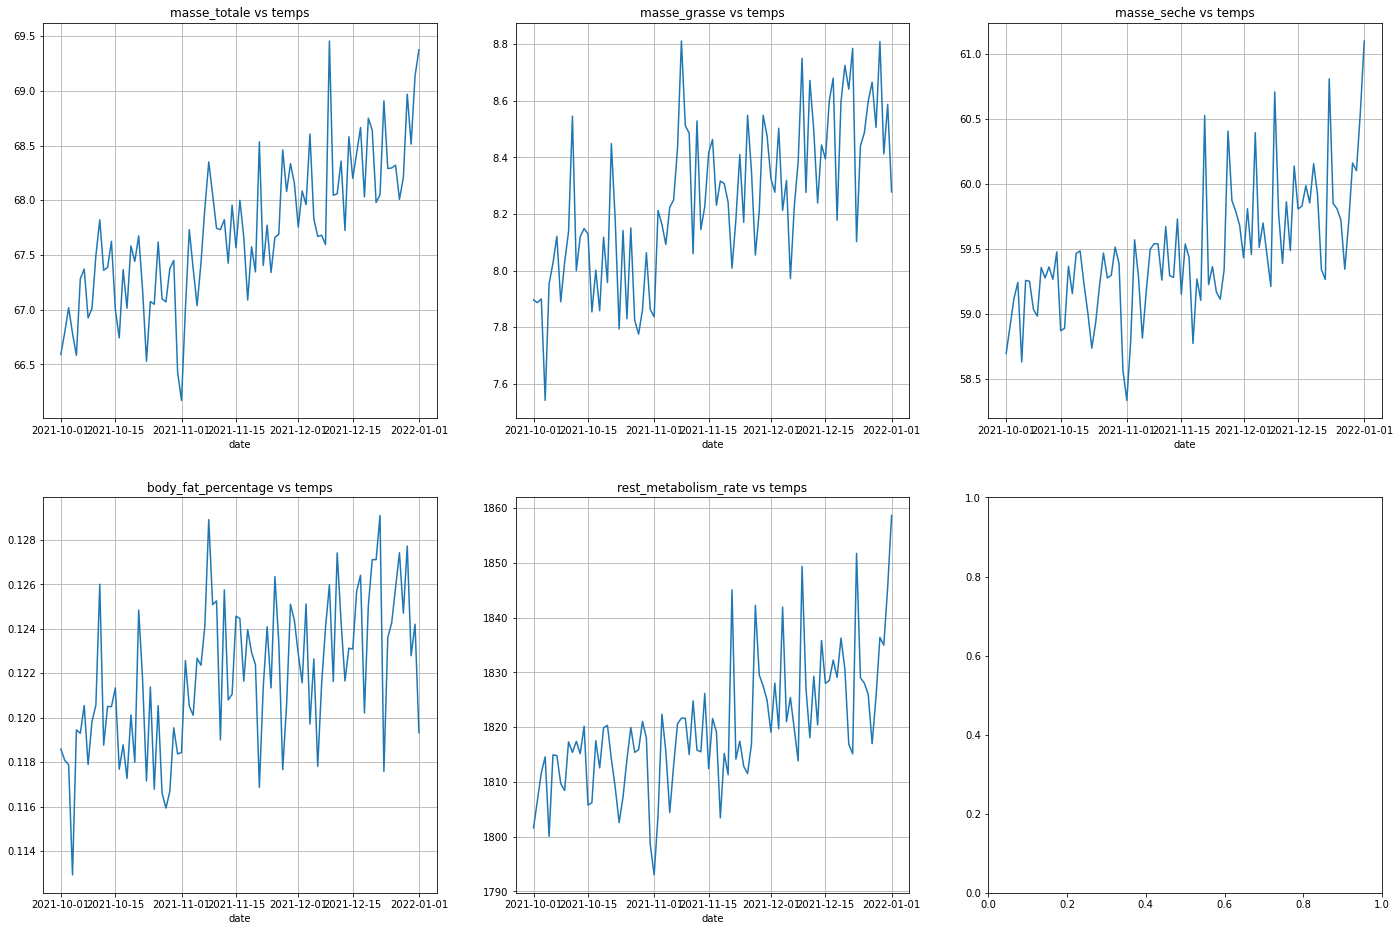

In [22]:
wl.plot_columns(df=df_bulk,
                columns_list=['masse_totale', 'masse_grasse', 'masse_seche', 'body_fat_percentage', 'rest_metabolism_rate']
)

# Quelles dynamiques sur les deux périodes ?

rythme mensuel moyen sur la période de masse_totale = -2.476 avec coeff correlation = 95.0%
rythme mensuel moyen sur la période de masse_seche = -0.861 avec coeff correlation = 92.0%
rythme mensuel moyen sur la période de body_fat_percentage = -0.014 avec coeff correlation = 97.0%


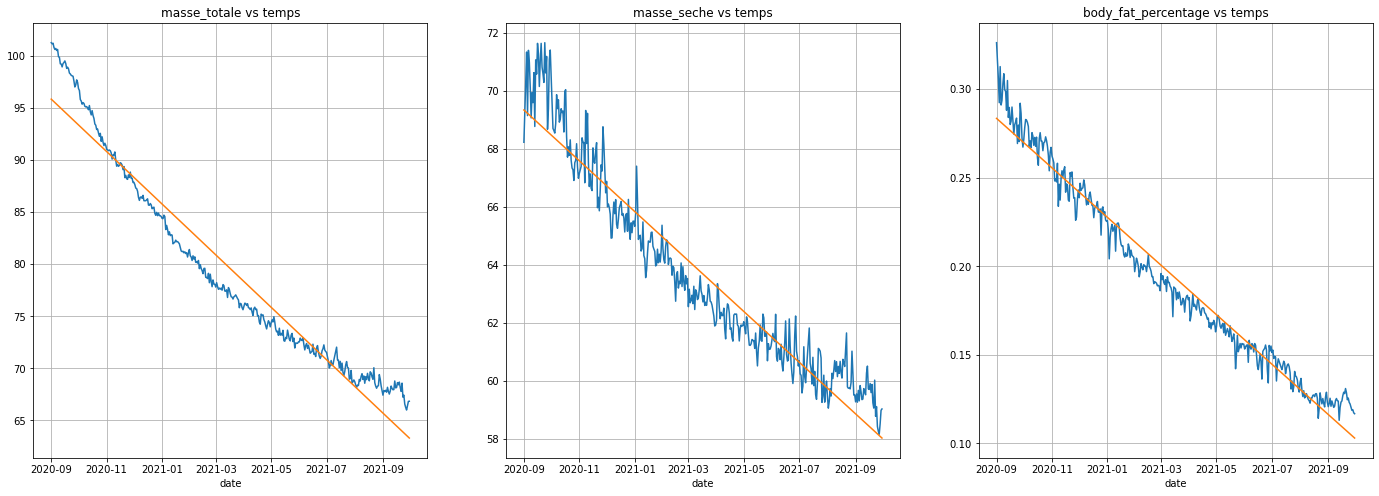

In [23]:
wl.plot_trends(df_seche)

rythme mensuel moyen sur la période de masse_totale = 0.571 avec coeff correlation = 61.0%
rythme mensuel moyen sur la période de masse_seche = 0.36 avec coeff correlation = 42.0%
rythme mensuel moyen sur la période de body_fat_percentage = 0.002 avec coeff correlation = 32.0%


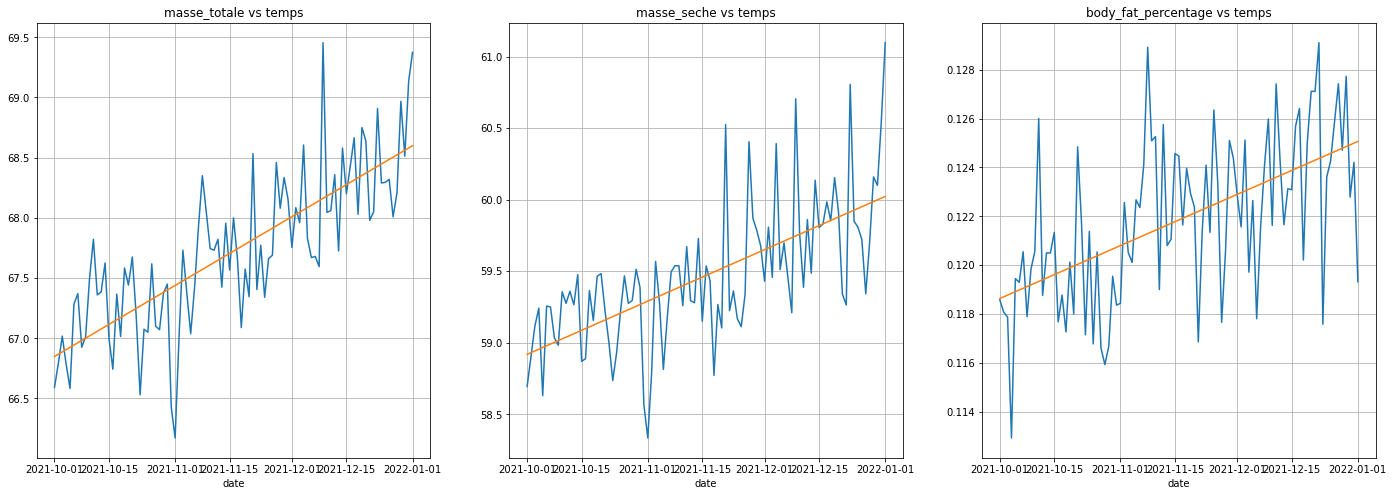

In [24]:
wl.plot_trends(df_bulk)

# Quelle(s) différence(s) principale(s) entre ces deux périodes ??

valeur médiane de calories_in pendant la période seche = 1831.0 kcals
valeur médiane de calories_in pendant la période bulk = 2108.0 kcals
---------------
valeur médiane de rest_metabolism_rate pendant la période seche = 1899.0 kcals
valeur médiane de rest_metabolism_rate pendant la période bulk = 1818.0 kcals
---------------
valeur médiane de calories_exercice_net pendant la période seche = 181.0 kcals
valeur médiane de calories_exercice_net pendant la période bulk = 365.0 kcals
---------------
valeur médiane de calories_deficit pendant la période seche = -221.0 kcals
valeur médiane de calories_deficit pendant la période bulk = -11.0 kcals
---------------


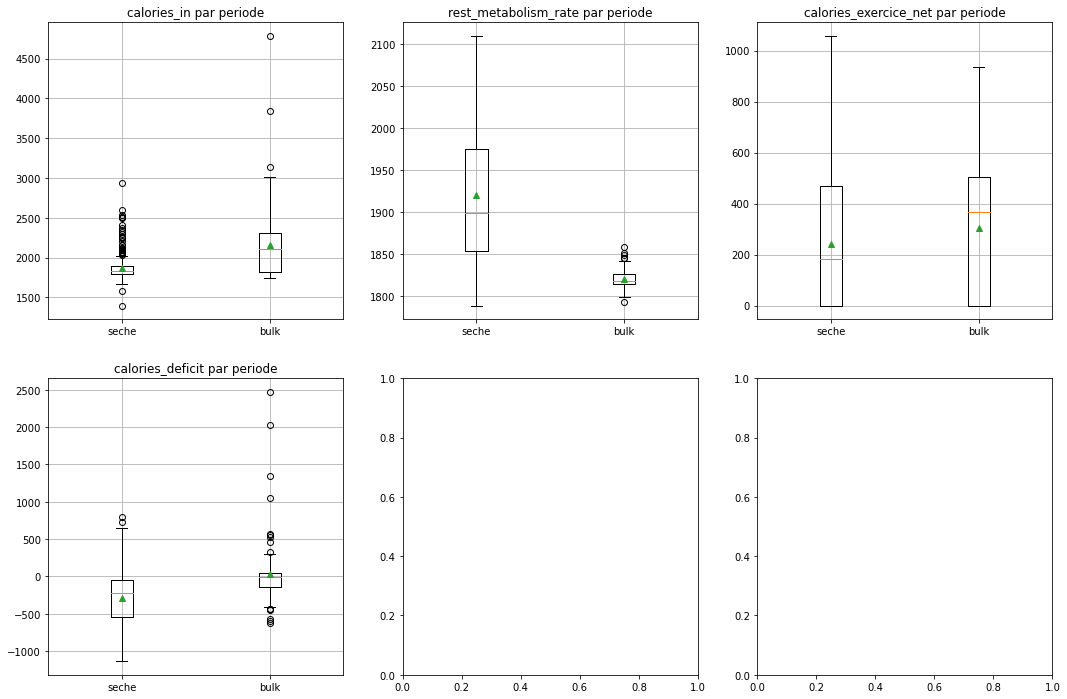

In [25]:
wl.plot_boxes(df_seche, df_bulk, columns_list=['calories_in', 'rest_metabolism_rate', 'calories_exercice_net', 'calories_deficit'])

### En regardant les médianes seules des deux périodes (certes de longueur différente)
le déficit calorique se rapproche de 0 pour le bulk

# Quelques corrélations

In [26]:
def get_periode(df):
    
    debut = df.index[0]
    fin = df.index[-1]
    periode_str = debut.strftime('%d/%m/%Y') + ' - ' + fin.strftime('%d/%m/%Y')
    return periode_str
    

In [27]:
def correlations_moyenne(df,
                         window=15, 
                         columns_y = ['masse_totale', 'masse_grasse', 'masse_seche'], 
                         y_list = ['variation_masse_totale_moyenne', 'variation_masse_grasse_moyenne', 'variation_masse_seche_moyenne'],
                         columns_x = ['calories_deficit', 'calories_cardio_net', 'calories_strength_net'],
                         x_list = ['calories_deficit_moyenne', 'calories_cardio_net_moyenne', 'calories_strength_net_moyenne']# , 'calories_cardio_moyenne', 'calories_strength_moyenne']
                         ):
    
    columns_y_variation_moyenne = [ 'variation_' + c + '_moyenne' for c in columns_y]
    columns_x_moyenne = [ c + '_moyenne' for c in columns_x]
    columns_all = columns_x + columns_y
    
    df_test = df[columns_all]
    
    name = get_periode(df)
    
    for c1, c2 in zip(columns_y, columns_y_variation_moyenne):
        df_test.loc[:,c2] = df_test[c1].diff(1).rolling(window).mean().to_numpy()
        
    for c1, c2 in zip(columns_x, columns_x_moyenne):
        df_test.loc[:,c2] = df_test[c1].rolling(window).mean().shift(1).to_numpy()
        
    df_test = df_test[window:]
    
    df_test.drop(columns = columns_x + columns_y, inplace=True)
    
    display(df_test.corr())
    
    nx = len(x_list)
    ny = len(y_list)
    unit_size = 6
    
    fig,ax = plt.subplots(ny, nx, figsize=(nx*unit_size, ny*unit_size))
    
    fig.suptitle('Periode : ' + name + f'\nValeurs quotidiennes moyennes sur une fenêtre de {window} jours')

    for r,y in enumerate(y_list):
        for c,x in enumerate(x_list):
            ax[r,c] = df_test.plot.scatter(x,y, ax = ax[r,c], grid=True)

    plt.savefig('figure.jpg', format='jpg')
    plt.show()
    

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,variation_masse_totale_moyenne,variation_masse_grasse_moyenne,variation_masse_seche_moyenne,calories_deficit_moyenne,calories_cardio_net_moyenne,calories_strength_net_moyenne
variation_masse_totale_moyenne,1.000000,0.801254,0.714769,0.885615,-0.825849,0.831668
variation_masse_grasse_moyenne,0.801254,1.000000,0.154268,0.824777,-0.784505,0.727397
variation_masse_seche_moyenne,0.714769,0.154268,1.000000,0.498387,-0.446766,0.523127
calories_deficit_moyenne,0.885615,0.824777,0.498387,1.000000,-0.935157,0.758953
calories_cardio_net_moyenne,-0.825849,-0.784505,-0.446766,-0.935157,1.000000,-0.725386
calories_strength_net_moyenne,0.831668,0.727397,0.523127,0.758953,-0.725386,1.000000


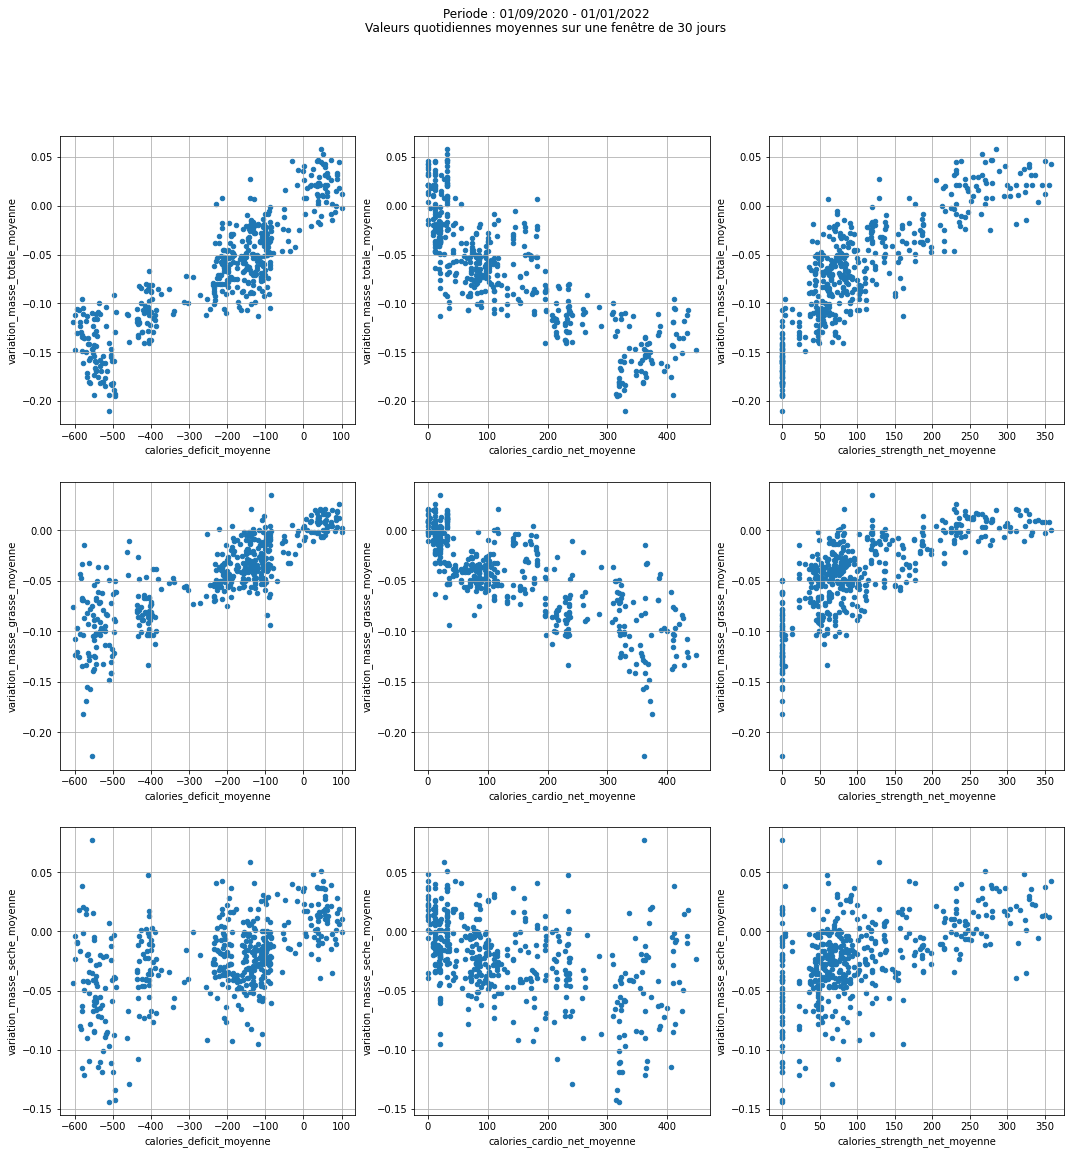

In [28]:
correlations_moyenne(df, window=30)

## Nouvelle politique :
- target déficit calorique quotidien : **-150 kcals** (rythme estimé : -750g graisse/mois, soit -1% body fat %age)
- target calories strength : 350 kcals net quotidien (soit, à 6 sessions/semaine : 410 kcals net/session, à 1h20 RMR 1830 kcals : **515 kcals brut / session, x 6 sessions/semaine** ) => target 450 kcals bruts quotidiens session 1h20
- (NB : deficit calorique = calories in - ( KMA + 10% + exercice ) )
- target MyFitnessPas : RMR 1830 + exercice net 350 - deficit 150 = 2030 ... on commence à **1900 kcals**

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


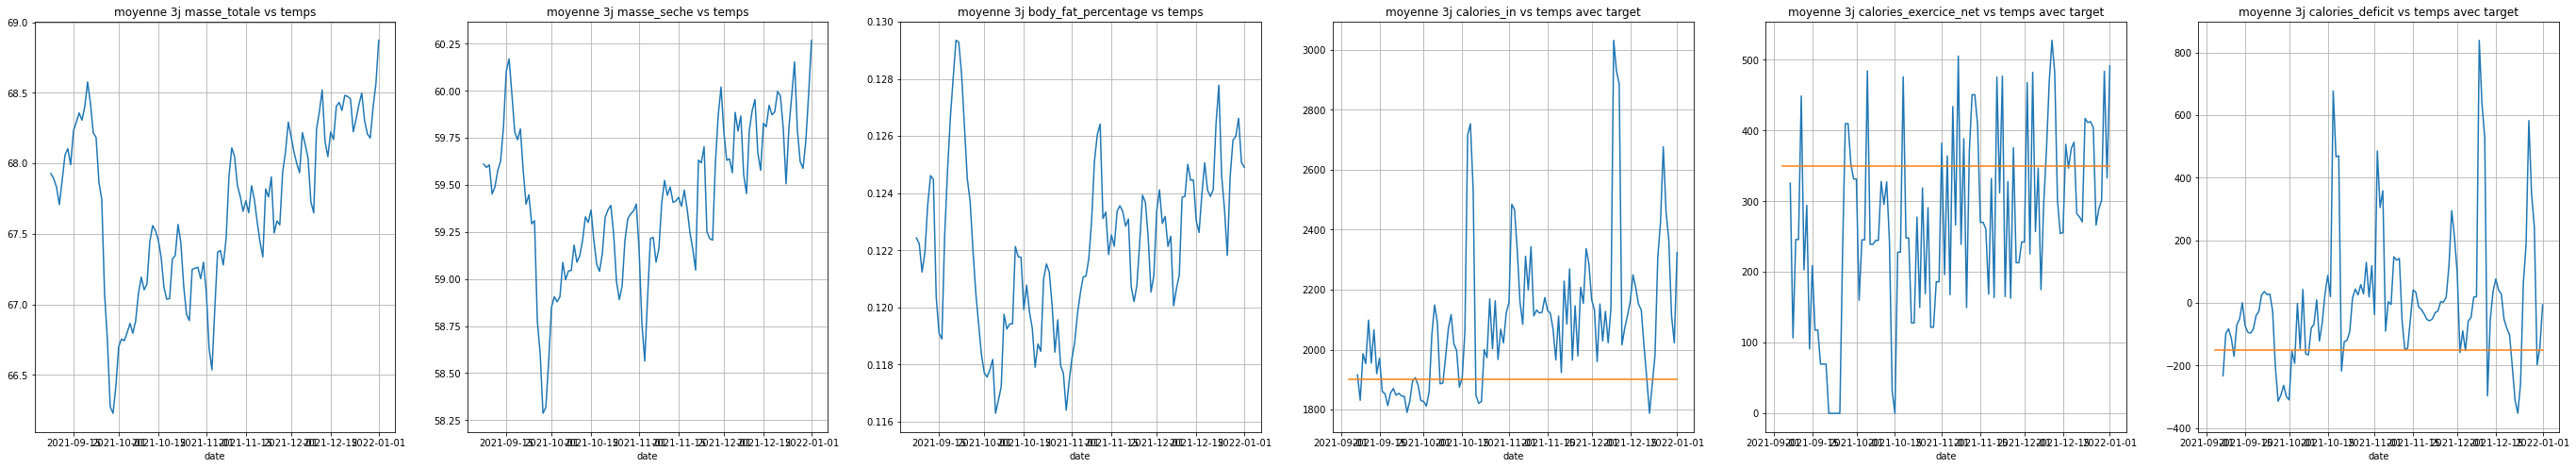

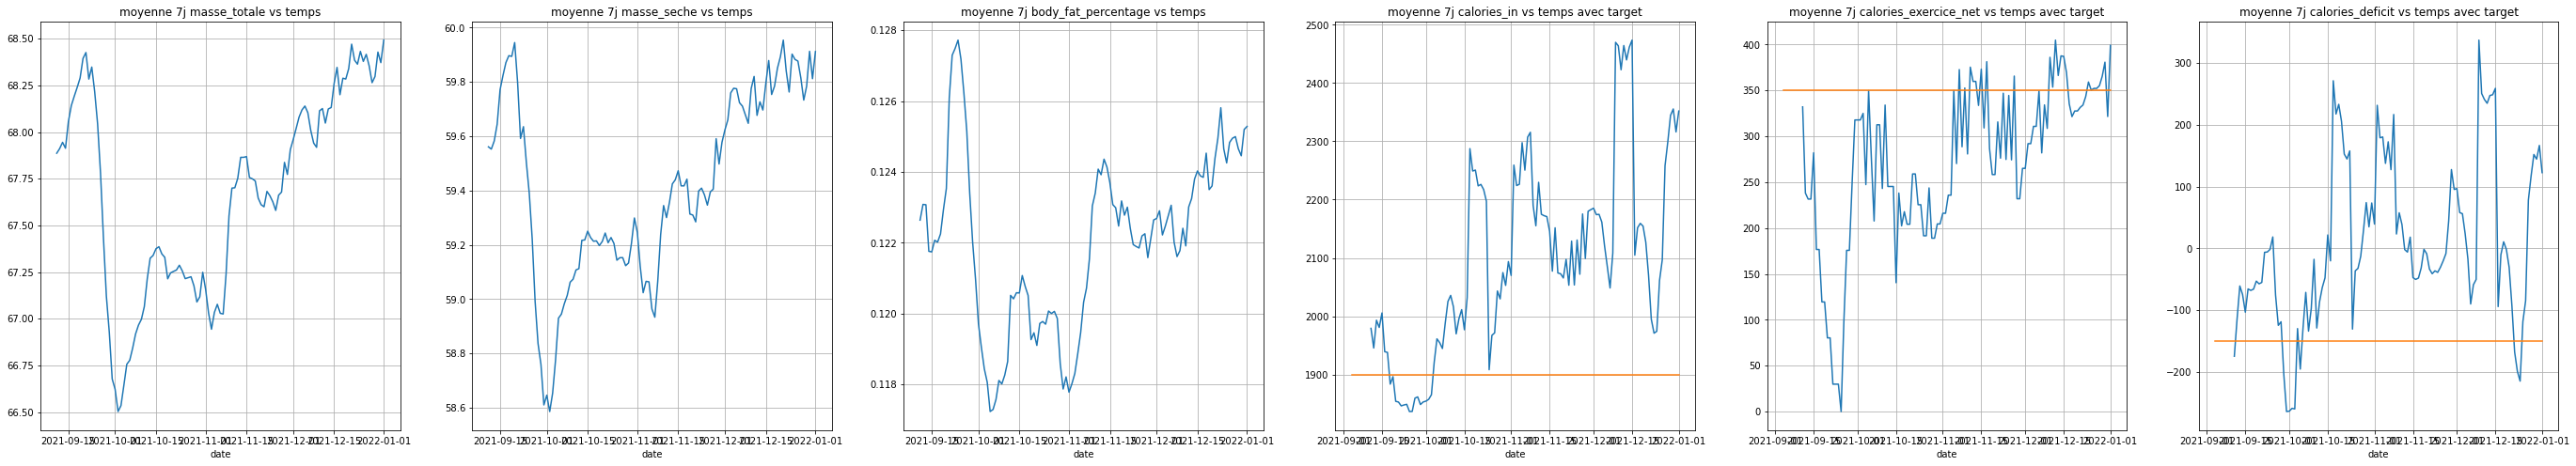

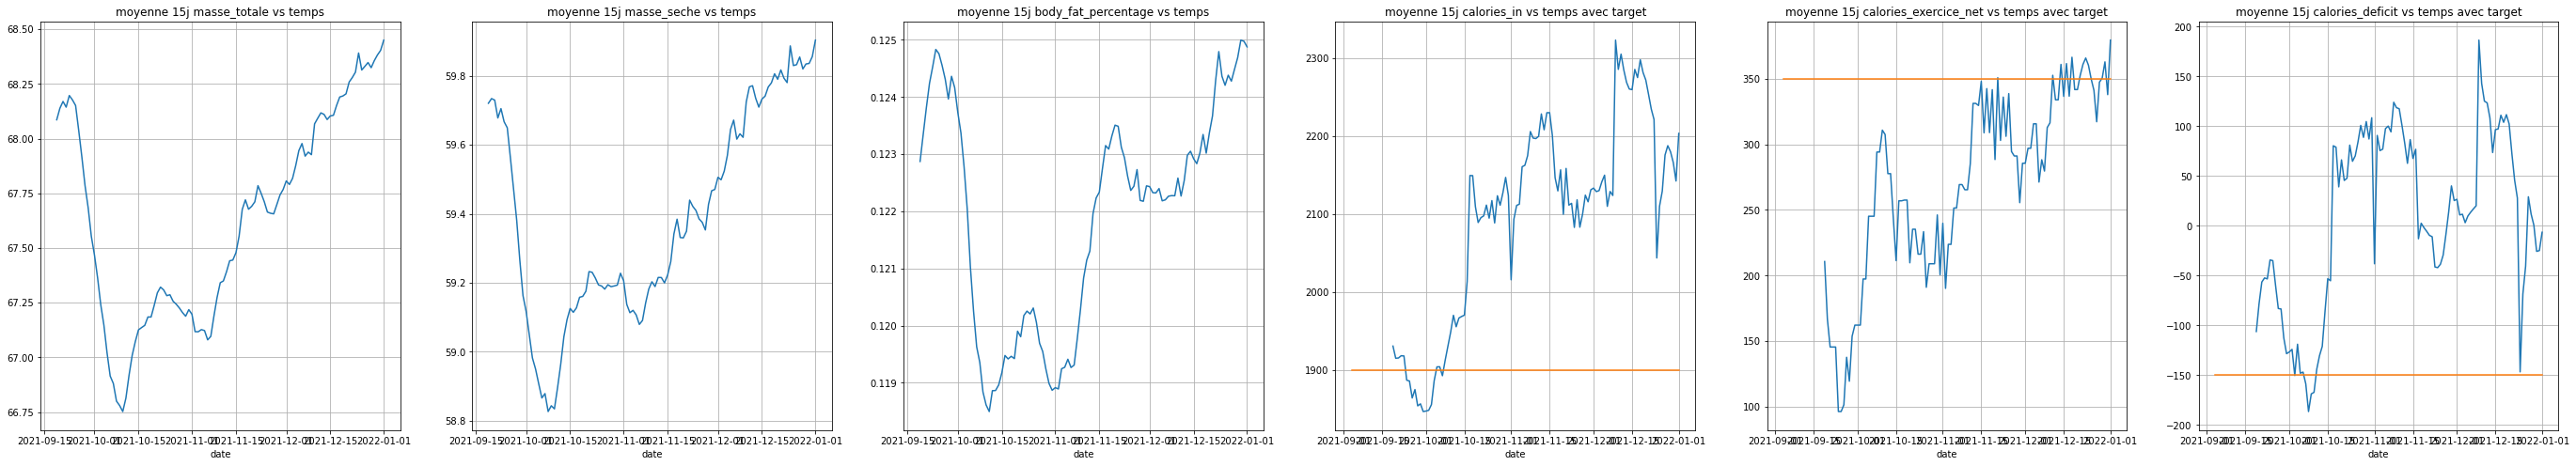

In [29]:
over_last_days = 120

start_date = datetime.date.today() - datetime.timedelta(days = over_last_days)
index_to_drop = [df.index < start_date]

df_last = df.drop(index = df.index[index_to_drop])

window_list = [3,7,15]

for w in window_list:
    wl.plot_moyennes_with_targets(df=df_last, list_of_moyennes=['masse_totale', 'masse_seche', 'body_fat_percentage', 'calories_in', 'calories_exercice_net', 'calories_deficit'], window=w)